In [20]:
import os
import time
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
from os import listdir
import pandas as pd
import numpy as np
import glob
import cv2
import json
from os.path import expanduser
import splitfolders
import shutil
from define_path import Def_Path

from tqdm import tqdm

import torch 
import torchvision
from torchvision import models
from torchvision.models.detection.rpn import AnchorGenerator
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn 
import torchvision.transforms as T
from torchvision.transforms import functional as F
from torchsummary import summary

from sklearn.model_selection import train_test_split

import albumentations as A # Library for augmentations

import matplotlib.pyplot as plt 
from PIL import Image

import transforms, utils, engine, train
from utils import collate_fn
from engine import train_one_epoch, evaluate

t = torch.cuda.get_device_properties(0).total_memory
print(t)
torch.cuda.empty_cache()

r = torch.cuda.memory_reserved(0)
print(r)
a = torch.cuda.memory_allocated(0)
print(a)
# f = r-a  # free inside reserved

weights_path = '/home/jc-merlab/Pictures/Data/trained_models/keypointsrcnn_weights_sim_b1_e25_v0.pth'

16908615680
0
0


In [21]:
# to generalize home directory. User can change their parent path without entering their home directory
path = Def_Path()

parent_path =  path.home + "/Pictures/" + "Data/"

root_dir = parent_path + path.year + "-" + path.month + "-" + path.day + "/"

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# torch.cuda.set_per_process_memory_fraction(0.9, 0)
print(device)

cuda


In [23]:
def train_transform():
    return A.Compose([
        A.Sequential([
            A.RandomRotate90(p=1), # Random rotation of an image by 90 degrees zero or more times
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.3, brightness_by_max=True, always_apply=False, p=1), # Random change of brightness & contrast
        ], p=1)
#         A.Resize(640, 480)  # Resize all images to be 640x480
    ],
    keypoint_params=A.KeypointParams(format='xy'), # More about keypoint formats used in albumentations library read at https://albumentations.ai/docs/getting_started/keypoints_augmentation/
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['bboxes_labels']) # Bboxes should have labels, read more at https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
    )

In [24]:
def train_test_split(src_dir):
    dst_dir_img = src_dir + "images"
    dst_dir_anno = src_dir + "annotations"
    
    if os.path.exists(dst_dir_img) and os.path.exists(dst_dir_anno):
        print("folders exist")
    else:
        os.mkdir(dst_dir_img)
        os.mkdir(dst_dir_anno)
        
    for jpgfile in glob.iglob(os.path.join(src_dir, "*.jpg")):
        shutil.copy(jpgfile, dst_dir_img)

    for jsonfile in glob.iglob(os.path.join(src_dir, "*.json")):
        shutil.copy(jsonfile, dst_dir_anno)
        
    output = parent_path + "split_folder_output" + "-" + path.year + "-" + path.month + "-" + path.day 
    
    splitfolders.ratio(src_dir, # The location of dataset
                   output=output, # The output location
                   seed=42, # The number of seed
                   ratio=(.7, .2, .1), # The ratio of split dataset
                   group_prefix=None, # If your dataset contains more than one file like ".jpg", ".pdf", etc
                   move=False # If you choose to move, turn this into True
                   )
    
    shutil.rmtree(dst_dir_img)
    shutil.rmtree(dst_dir_anno)
    
    return output  
    

In [25]:
class KPDataset(Dataset):
    def __init__(self, root, transform=None, demo=False):                
        self.root = root
        self.transform = transform
        self.demo = demo # Use demo=True if you need transformed and original images (for example, for visualization purposes)
        self.imgs_files = sorted(os.listdir(os.path.join(root, "images")))
        self.annotations_files = sorted(os.listdir(os.path.join(root, "annotations")))
    
    def __getitem__(self, idx):
        img_file = self.imgs_files[idx]
        img_path = os.path.join(self.root, "images", self.imgs_files[idx])
        annotations_path = os.path.join(self.root, "annotations", self.annotations_files[idx])

        img_original = cv2.imread(img_path)
        img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
        
        with open(annotations_path) as f:
            data = json.load(f)
            bboxes_original = data['bboxes']
            keypoints_original = data['keypoints']
            
            # All objects are keypoints on the robot
            bboxes_labels_original = [] 
            bboxes_labels_original.append('base_joint')
            bboxes_labels_original.append('joint2')
            bboxes_labels_original.append('joint3')
            bboxes_labels_original.append('joint4')
            bboxes_labels_original.append('joint5')
            bboxes_labels_original.append('joint6')  

        if self.transform:   
            # Converting keypoints from [x,y,visibility]-format to [x, y]-format + Flattening nested list of keypoints            
            # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
            # [[obj1_kp1, obj1_kp2], [obj2_kp1, obj2_kp2], [obj3_kp1, obj3_kp2]], where each keypoint is in [x, y]-format            
            # Then we need to convert it to the following list:
            # [obj1_kp1, obj1_kp2, obj2_kp1, obj2_kp2, obj3_kp1, obj3_kp2]
            keypoints_original_flattened = [el[0:2] for kp in keypoints_original for el in kp]
            
            # Apply augmentations
            transformed = self.transform(image=img_original, bboxes=bboxes_original, bboxes_labels=bboxes_labels_original, keypoints=keypoints_original_flattened)
            img = transformed['image']
            bboxes = transformed['bboxes']
            # Unflattening list transformed['keypoints']
            # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
            # [obj1_kp1, obj1_kp2, obj2_kp1, obj2_kp2, obj3_kp1, obj3_kp2], where each keypoint is in [x, y]-format
            # Then we need to convert it to the following list:
            # [[obj1_kp1, obj1_kp2], [obj2_kp1, obj2_kp2], [obj3_kp1, obj3_kp2]]
            keypoints_transformed_unflattened = np.reshape(np.array(transformed['keypoints']), (-1,1,2)).tolist()

            # Converting transformed keypoints from [x, y]-format to [x,y,visibility]-format by appending original visibilities to transformed coordinates of keypoints
            keypoints = []
            for o_idx, obj in enumerate(keypoints_transformed_unflattened):
#                 print("object", obj)
#                 print(" obj index", o_idx)# Iterating over objects
                obj_keypoints = []
                for k_idx, kp in enumerate(obj): # Iterating over keypoints in each object
                    obj_keypoints.append(kp + [keypoints_original[o_idx][k_idx][2]])
                keypoints.append(obj_keypoints)
        
        else:
            img, bboxes, keypoints = img_original, bboxes_original, keypoints_original        
        
        # Convert everything into a torch tensor        
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)       
        target = {}
        labels = [1, 2, 3, 4, 5, 6]            
        target["boxes"] = bboxes
        target["labels"] = torch.as_tensor(labels, dtype=torch.int64) # all objects are joint positions
        target["image_id"] = torch.tensor([idx])
        target["area"] = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        target["iscrowd"] = torch.zeros(len(bboxes), dtype=torch.int64)
        target["keypoints"] = torch.as_tensor(keypoints, dtype=torch.float32)
        img = F.to_tensor(img)        
        bboxes_original = torch.as_tensor(bboxes_original, dtype=torch.float32)
        target_original = {}
        target_original["boxes"] = bboxes_original
        target_original["labels"] = torch.as_tensor(labels, dtype=torch.int64) # all objects are glue tubes
        target_original["image_id"] = torch.tensor([idx])
        target_original["area"] = (bboxes_original[:, 3] - bboxes_original[:, 1]) * (bboxes_original[:, 2] - bboxes_original[:, 0])
        target_original["iscrowd"] = torch.zeros(len(bboxes_original), dtype=torch.int64)
        target_original["keypoints"] = torch.as_tensor(keypoints_original, dtype=torch.float32)        
        img_original = F.to_tensor(img_original)

        if self.demo:
            return img, target, img_original, target_original, img_file
        else:
            return img, target, img_file
    
    def __len__(self):
        return len(self.imgs_files)

In [26]:
def get_model(num_keypoints, weights_path=None):
    
    anchor_generator = AnchorGenerator(sizes=(32, 64, 128, 256, 512), aspect_ratios=(0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0))
    model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=False,
                                                                   pretrained_backbone=True,
                                                                   num_keypoints=num_keypoints,
                                                                   num_classes = 7, # Background is the first class, object is the second class
                                                                   rpn_anchor_generator=anchor_generator)

    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)        
        
    return model

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as func
import networkx as nx


class GNNEncoder(nn.Module):
    def __init__(self, vertices_dim=5, hidden_dim=128, num_vertices=6):
        super(GNNEncoder, self).__init__()
        self.f_enc = nn.Linear(vertices_dim, hidden_dim)
        self.f_e1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.f_v = nn.Linear(hidden_dim, hidden_dim)
        self.f_e2 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.num_vertices = num_vertices
        
    def generate_edges(self, vertices):
        vertices_list = vertices.tolist()
        G = nx.Graph()
        for idx, vertex in enumerate(vertices_list):
            G.add_node(idx, x=vertex[0], y=vertex[1], t=vertex[2], vis=vertex[3])  
            if idx < len(vertices_list) - 1:
                G.add_edge(idx, idx + 1)
        # Add the edge between the last and the first vertex to form a cycle
        G.add_edge(len(vertices_list) - 1, 0)
        edges = torch.tensor(list(G.edges), dtype=torch.long).to(vertices.device)
        return edges

#     def generate_edges(self, vertices):
#         vertices_list = vertices.tolist()
#         G = nx.Graph()
#         for idx, vertex in enumerate(vertices_list):
#             G.add_node(idx, x=vertex[0], y=vertex[1], t=vertex[2])  
#             if idx < len(vertices_list) - 1:
#                 G.add_edge(idx, idx + 1)
#         edges = torch.tensor(list(G.edges), dtype=torch.long).to(vertices.device)
#         return edges
    
#     def generate_edges(self, vertices):
#         num_vertices = vertices.shape[0]
#         all_edges = [[i, j] for i in range(num_vertices) for j in range(i+1, num_vertices)]
#         edges = torch.tensor(all_edges, dtype=torch.long).to(vertices.device)
#         return edges

    def forward(self, vertices):
        h1 = self.f_enc(vertices)
        edges = self.generate_edges(vertices)
#         print(edges)
        h1_source = h1[edges[:, 0]]
        h1_target = h1[edges[:, 1]]
        h_e1 = self.f_e1(torch.cat((h1_source, h1_target), dim=1))
        h_j_2 = self.f_v(h_e1)
        h2_source = h_j_2[edges[:, 0]]
        h2_target = h_j_2[edges[:, 1]]
        h_e2 = self.f_e2(torch.cat((h2_source, h2_target), dim=1))
        h_e2_prob = torch.sigmoid(h_e2)
        return vertices, h_e2_prob, edges

class GNNDecoder(nn.Module):
    def __init__(self, vertices_dim=5, hidden_dim=128, num_vertices=6):
        super(GNNDecoder, self).__init__()
        self.f_e = nn.Linear(vertices_dim * 2, hidden_dim)  # Concatenate two vertices features
        self.f_h = nn.Linear(hidden_dim, vertices_dim)  # Transform h_ij to the same dimension as vertices
        self.f_v = nn.Linear(vertices_dim, vertices_dim)  # Update vertex feature

    def forward(self, vertices, h_e2_prob, edges):
        h_source = vertices[edges[:, 0]]
        h_target = vertices[edges[:, 1]]
        h = torch.zeros_like(vertices)

        for idx, (i, j) in enumerate(edges):  # Iterate over edges
            h_ij = h_e2_prob[idx] * self.f_e(torch.cat((h_source[idx], h_target[idx]), dim=0))  # Apply edge function
            h_ij_transformed = self.f_h(h_ij)  # Transform h_ij to the same dimension as vertices
            h[j] += h_ij_transformed  # Accumulate edge features to the target vertex

        h_transformed = self.f_v(h.view(-1, vertices.shape[1]))  # Transform h
        h_transformed = h_transformed.view(vertices.shape)  # Reshape back to original shape
        vertices_g = vertices + h_transformed  # Update vertex features

        return vertices_g  # Return vertices_g as the prediction and vertices_g itself as the mean for Gaussian distribution



In [100]:
# class TrifocalLoss(nn.Module):
#     def __init__(self):
#         super().__init__()

#     def forward(self, vertices_pred, vertices_gt):
#         # Only consider the first two dimensions
#         vertices_pred = vertices_pred[:, :3]
#         vertices_gt = vertices_gt.squeeze()[:, :3]  # Use squeeze() to remove the singular dimension

#         loss = (vertices_gt - torch.tensor(vertices_pred)).pow(2).mean()  # Changed from sum() to mean()
#         return loss
# class HuberLoss(nn.Module):
#     def __init__(self, delta=1.0):
#         super().__init__()
#         self.delta = delta

#     def forward(self, vertices_pred, vertices_gt):
#         vertices_pred = vertices_pred[:, :3]
#         vertices_gt = vertices_gt.squeeze()[:, :3]
#         diff = (vertices_gt - vertices_pred).abs()
#         loss = torch.where(diff < self.delta, 0.5 * diff.pow(2), self.delta * (diff - 0.5 * self.delta))
#         return loss.mean()
# def cross_entropy_loss_func(edges_prob, edges_gt):
#     edges_gt_expanded = edges_gt.unsqueeze(-1).float()
#     loss_func = nn.BCEWithLogitsLoss()
#     loss = loss_func(edges_prob, edges_gt_expanded)
#     return loss
    
# class VisibleHuberLoss(nn.Module):
#     def __init__(self, delta=1.0):
#         super().__init__()
#         self.delta = delta

#     def forward(self, vertices_pred, vertices_gt):
#         print("Vertice_gt inside huber", vertices_gt)
#         visibility = vertices_gt[:, 3]  # extracting the visibility
#         vertices_pred = vertices_pred[:, :3]  # considering only x, y coordinates, confidence_score
#         vertices_gt = vertices_gt.squeeze()[:, :3]  # considering only x, y coordinates, confidence_score
#         print(f'vertices_pred shape: {vertices_pred.shape}')  # Debugging print
#         print(f'vertices_gt shape: {vertices_gt.shape}')  # Debugging print
#         diff = (vertices_gt - vertices_pred).abs()
#         loss = torch.where(diff < self.delta, 0.5 * diff.pow(2), self.delta * (diff - 0.5 * self.delta))
#         # Multiply by visibility
#         weighted_loss = visibility[:, None] * loss  # using None to keep dimensions consistent
#         return weighted_loss.mean()

class OccludedKeyPointLoss(nn.Module):
    def __init__(self, delta=1.0):
        super().__init__()
        self.delta = delta

    def forward(self, vertices_pred, vertices_gt):
        vertices_gt = vertices_gt.squeeze()
        print(vertices_gt.shape)
        visibility = vertices_gt[:, 3].unsqueeze(1)  # Extracting the visibility
#         visibility = visibility[:, :, :3]
        print(visibility)
        vertices_pred = vertices_pred[:, :3]  # Considering only x, y coordinates, confidence_score
        print(vertices_pred.shape)
        vertices_gt = vertices_gt[:, :3]  # Considering only x, y coordinates, confidence_score
        print(vertices_gt.shape)

        # Compute differences
        diff = (vertices_gt - vertices_pred).abs()

        # Huber loss for visible keypoints
        visible_loss = torch.where(visibility == 1.0, 
                                   torch.where(diff < self.delta, 0.5 * diff.pow(2), self.delta * (diff - 0.5 * self.delta)), 
                                   torch.tensor(0.0).to(vertices_pred.device))

        # For occluded keypoints, compute the distance to the nearest visible keypoint
        occluded_loss = torch.tensor(0.0).to(vertices_pred.device)
        if torch.any(visibility == 0.0):
            occluded_diff = vertices_pred[visibility == 0.0] - vertices_gt[visibility == 1.0][:, None]
            min_occluded_dist = occluded_diff.pow(2).sum(dim=-1).min(dim=0)[0].sqrt()
            occluded_loss = torch.where(diff < self.delta, 0.5 * min_occluded_dist.pow(2), self.delta * (min_occluded_dist - 0.5 * self.delta))

        # Total loss is the sum of the visible loss and the occluded loss
        loss = visible_loss.sum() + occluded_loss.sum()
        return loss

def edge_loss(edges_prob, edges_gt):
    # Expand edges_gt to match the shape of edges_prob
#     print(edges_prob.shape)
    edges_gt_expanded = torch.zeros(edges_prob.shape, dtype=torch.float32)
    
    for i in range(edges_gt.shape[0]):
        u, v = edges_gt[i]
#         print("u:", u)
#         print("v:", v)
#         print("edges_gt_expanded.shape:", edges_gt_expanded.shape)
        if i < edges_gt_expanded.shape[0]:
            if u < edges_gt_expanded.shape[1]:
                edges_gt_expanded[i, u] = 1
            if v < edges_gt_expanded.shape[1]:
                edges_gt_expanded[i, v] = 1
#         print('new u', u)
#         print('new v', v)
    # Compute the cross-entropy loss
    loss = -torch.sum(edges_gt_expanded.to(device) * torch.log(torch.clamp(edges_prob, min=1e-7)))
                      
    return loss



In [101]:
# class KeypointPipeline(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.keypoint_model = torch.load(weights_path).to(device)
#         self.keypoint_model.eval()  # Set the model to evaluation mode
#         self.keypoint_model = self.keypoint_model.to(device)
#         self.gnn_encoder = GNNEncoder()
#         self.gnn_decoder = GNNDecoder()
        
#     def forward(self, imgs):
#         outputs = []
#         for i in range(imgs.shape[0]):
#             img = imgs[i].unsqueeze(0).to(device)  # Unsqueeze the 0th dimension to make a batch of size 1
#             # Temporarily set the keypoint model to evaluation mode
#             keypoint_model_training = self.keypoint_model.training  # Save the current mode
#             self.keypoint_model.eval()
#             with torch.no_grad():
#                 output = self.keypoint_model(img)  # Keypoint model expects a list of images
                
#             # Set the keypoint model back to its previous mode
#             self.keypoint_model.train(keypoint_model_training)
                
#             img = (img[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
#             scores = output[0]['scores'].detach().cpu().numpy()
#             high_scores_idxs = np.where(scores > 0.7)[0].tolist() # Indexes of boxes with scores > 0.7
#             post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], \
#                 output[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

#             keypoints = []
#             key_points = []
#             for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
#                 keypoints.append(list(map(int, kps[0,0:2])))
#                 key_points.append([list(map(int, kp[:2])) for kp in kps])

# #             print("keypoints", keypoints)

#             labels = []
#             for label in output[0]['labels'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
#                 labels.append(label)
#     #             labels.append('j' + str(int(label)))
    
#             print("keypoints", keypoints)

# #             print("labels", labels)

# #             keypoints_ = [x for _,x in sorted(zip(labels,keypoints))]
#     #         kp_label = [list(x) + [y] for (x, y) in sorted(zip(keypoints, labels))]

#             # Create a dictionary where the key is the label and the value is the keypoint
#             label_keypoint_dict = {lbl: kp for kp, lbl in zip(keypoints, labels)}

#             # Convert the dictionary back to a list and sort it by the label keys
#             labeled_keypoints = [value + [key] for key, value in sorted(label_keypoint_dict.items())] #,key=lambda item: int(item[0][1:]))]

# #             print("keypoints_", keypoints_)
#             print("kp_label", labeled_keypoints)
# # 
#             keypoints = torch.stack([torch.tensor(kp) for kp in labeled_keypoints]).float().to(device)
#             vertices, enc_e, edges = self.gnn_encoder(keypoints)
#             updated_vertices = self.gnn_decoder(vertices, enc_e, edges)
#             outputs.append((updated_vertices, enc_e, edges))

#         return outputs  # A list of tuples, each containing updated_vertices, enc_e, edges for an image in the batch



In [102]:
class KeypointPipeline(nn.Module):
    def __init__(self, weights_path, num_vertices):
        super().__init__()

        self.keypoint_model = torch.load(weights_path).to(device)
        self.num_vertices = num_vertices
        self.gnn_encoder = GNNEncoder()
        self.gnn_decoder = GNNDecoder()

    def process_model_output(self, output):
        scores = output[0]['scores'].detach().cpu().numpy()
        high_scores_idxs = np.where(scores > 0.7)[0].tolist()

        post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], 
                                            output[0]['scores'][high_scores_idxs], 0.3).cpu().numpy()

        confidence = output[0]['scores'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy()
        labels = output[0]['labels'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy()
        keypoints = []
        for idx, kps in enumerate(output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy()):
            # Setting t_i = 1 because label is found
            keypoints.append(list(map(int, kps[0,0:2])) + [confidence[idx]] + [1] + [labels[idx]])

        # Create a dictionary where the key is the label and the value is the keypoint
        label_to_keypoint = {}
        for idx, kps in enumerate(output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy()):
            # Setting t_i = 1 because label is found
            keypoints.append(list(map(int, kps[0,0:2])) + [confidence[idx]] + [1] + [labels[idx]])

        # Use a dictionary to keep track of all possible keypoints and their locations.
        # Initialize with placeholders for missing keypoints.
        all_keypoints = {i: [-1, -1, 0, 0, i] for i in range(1, self.num_vertices+1)}  # added another 0 for t_i

        for keypoint in keypoints:
            label = keypoint[-1]
            if label not in label_to_keypoint or label_to_keypoint[label][-2] < keypoint[-2]:
                all_keypoints[label] = keypoint

        # Convert the dictionary values back into a list
        keypoints = list(all_keypoints.values())
        return keypoints

#         keypoints = []
#         for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
#             keypoints.append(list(map(int, kps[0,0:2])))

#         labels = []
#         for label in output[0]['labels'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
#             labels.append(label)

#         label_keypoint_dict = {lbl: kp for kp, lbl in zip(keypoints, labels)}
#         labeled_keypoints = [value + [key] for key, value in sorted(label_keypoint_dict.items())]

        return keypoints

    def process_image(self, img):
        img = img.unsqueeze(0).to(device)
        # Temporarily set the keypoint model to evaluation mode
        keypoint_model_training = self.keypoint_model.training  # Save the current mode
        self.keypoint_model.eval()
        with torch.no_grad():
            output = self.keypoint_model(img)
        # Set the keypoint model back to its previous mode
        self.keypoint_model.train(keypoint_model_training)
        img = (img[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
        labeled_keypoints = self.process_model_output(output)

        return labeled_keypoints

    def forward(self, imgs):
        outputs = []

        for i in range(imgs.shape[0]):
            labeled_keypoints = self.process_image(imgs[i])
            keypoints = torch.stack([torch.tensor(kp) for kp in labeled_keypoints]).float().to(device)

            vertices, enc_e, edges = self.gnn_encoder(keypoints)
            updated_vertices = self.gnn_decoder(vertices, enc_e, edges)
            outputs.append((updated_vertices, enc_e, edges))

        return outputs
    

In [103]:
# class KeypointPipeline(nn.Module):
#     def __init__(self, num_keypoints, weights_path=None):
#         super().__init__()

#         # Instantiate your Keypoint R-CNN model
#         self.keypoint_model = get_model(num_keypoints, weights_path)
#         self.keypoint_model.to(device)

#         self.gnn_encoder = GNNEncoder()
#         self.gnn_decoder = GNNDecoder()

#     def process_model_output(self, output):
#         scores = output[0]['scores'].detach().cpu().numpy()
#         high_scores_idxs = np.where(scores > 0.7)[0].tolist()

#         post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], 
#                                             output[0]['scores'][high_scores_idxs], 0.3).cpu().numpy()

#         keypoints = []
#         for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
#             keypoints.append(list(map(int, kps[0,0:2])))

#         labels = []
#         for label in output[0]['labels'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
#             labels.append(label)

#         label_keypoint_dict = {lbl: kp for kp, lbl in zip(keypoints, labels)}
#         labeled_keypoints = [value + [key] for key, value in sorted(label_keypoint_dict.items())]

#         return labeled_keypoints

#     def process_image(self, img):
#         img = img.unsqueeze(0).to(device)
#         # Temporarily set the keypoint model to evaluation mode
#         keypoint_model_training = self.keypoint_model.training  # Save the current mode
#         self.keypoint_model.eval()
#         with torch.no_grad():
#             output = self.keypoint_model(img)
#         print("Output", output)
#         # Set the keypoint model back to its previous mode
#         self.keypoint_model.train(keypoint_model_training)
#         img = (img[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
#         labeled_keypoints = self.process_model_output(output)

#         return labeled_keypoints

#     def forward(self, imgs):
#         outputs = []

#         for i in range(imgs.shape[0]):
#             labeled_keypoints = self.process_image(imgs[i])
#             keypoints = torch.stack([torch.tensor(kp) for kp in labeled_keypoints]).float().to(device)

#             vertices, enc_e, edges = self.gnn_encoder(keypoints)
#             updated_vertices = self.gnn_decoder(vertices, enc_e, edges)
#             outputs.append((updated_vertices, enc_e, edges))

#         return outputs

In [104]:
# Define the model
model = KeypointPipeline(weights_path, num_vertices=6)
model = model.to(device)

# Define the loss
criterion = OccludedKeyPointLoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 30  # Define your number of epochs
batch_size = 4

KEYPOINTS_FOLDER_TRAIN = train_test_split(root_dir) +"/train" #train_test_split(root_dir) +"/train"
KEYPOINTS_FOLDER_VAL = train_test_split(root_dir) +"/val"
KEYPOINTS_FOLDER_TEST = train_test_split(root_dir) +"/test"

dataset_train = KPDataset(KEYPOINTS_FOLDER_TRAIN, transform=None, demo=False)
dataset_val = KPDataset(KEYPOINTS_FOLDER_VAL, transform=None, demo=False)
dataset_test = KPDataset(KEYPOINTS_FOLDER_TEST, transform=None, demo=False)

data_loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
data_loader_val = DataLoader(dataset_val, batch_size=1, shuffle=False, collate_fn=collate_fn)
data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)
v = 2
model.train()
for epoch in range(num_epochs):
    start_time = time.time()
    for i, batch in enumerate(data_loader_train):
        img_tuple, target_dict_tuple, img_files = batch
        print(f"Processing batch {i+1} with images:", img_files)
        
        imgs = [img.to(device) for img in img_tuple]  # Create list of images

        # Process each image individually
        losses = []
        for i in range(len(imgs)):
            img = imgs[i].unsqueeze(0)  # Unsqueeze to add batch dimension

            # Prepare ground truth vertices for the image
            keypoints = target_dict_tuple[i]['keypoints'].to(device)
            visibility = torch.ones((keypoints.shape[0], keypoints.shape[1], 1)).to(device)
            vertices_gt = torch.cat((keypoints, visibility), dim=2).unsqueeze(0)  # Unsqueeze to add batch dimension

            # Forward pass
            output = model(img)
            vertices_pred, edges_prob, edges_gt = output[0]

            # Compute loss for the image
            huber_loss = criterion(vertices_pred, vertices_gt)
            ce_loss = edge_loss(edges_prob, edges_gt)

            loss = huber_loss + ce_loss
            losses.append(loss)  # Store loss for the image

        # Average loss over all images in the batch
        loss = torch.mean(torch.stack(losses))

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

    end_time = time.time()
    epoch_time = end_time - start_time
    eta = epoch_time * (num_epochs - epoch - 1)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, ETA: {eta} seconds')

model_save_path = f"/home/jc-merlab/Pictures/Data/trained_models/keypointsrcnn_weights_occ_b{batch_size}_e{num_epochs}_v{v}.pth"

torch.save(model, model_save_path)
    
# Save the state dict of the model, not the entire model
# torch.save(model.state_dict(), model_save_path)
    
torch.save(model, model_save_path)


# model.train()
# # Epoch loop
# for epoch in range(num_epochs):
#     # For each batch in your training data
#     for batch in data_loader_train:
#         img_tuple, target_dict_tuple = batch
#         img = img_tuple[0]
# #         print(img.shape)
#         target = target_dict_tuple[0]
#         img = img.to(device)
#         vertices_gt = target['keypoints'].to(device)
#         num_vertices = vertices_gt.shape[0]
#         print(num_vertices)
#         vertices_gt[:, :, 2] = torch.arange(1, num_vertices+1).unsqueeze(1).to(device)

#         # Forward pass
#         vertices_pred, edges_prob, edges_gt = model(img)
        
#         # Compute the losses
#         trifocal_loss = criterion(vertices_pred, vertices_gt)
#         ce_loss = edge_loss(edges_prob, edges_gt)

#         # Combined loss
#         loss = trifocal_loss + ce_loss
# #         loss = trifocal_loss

#         # Backward pass and optimization
#         optimizer.zero_grad()
#         loss.backward()
        
#         optimizer.step()

#     # Print loss for each epoch
#     print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

Copying files: 2662 files [00:00, 18701.08 files/s]
Copying files: 2662 files [00:00, 18405.99 files/s]
Copying files: 2662 files [00:00, 18317.99 files/s]


Processing batch 1 with images: ('000847.rgb.jpg', '000169.rgb.jpg', '000869.rgb.jpg', '001192.rgb.jpg')
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])
torch.Size([6, 4])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([6, 3])
torch.Size([6, 3])


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [15]:
def visualize_and_save(img, vertices, filename):
    print("type of image befor conversion",type(img))    
    print("type of vertices before conversion", type(vertices))
    print(img)
    img = (img.permute(1,2,0).cpu().numpy() * 255).astype(np.uint8)
#     img = (img * 255).astype(np.uint8)  # Convert back from [0, 1] range to [0, 255]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    vertices = vertices.cpu().numpy()

    print(f"Image shape before saving: {img.shape}")  # print the image shape
    print("type of vertices", type(vertices))
#     print("entered vertices", vertices)
#     print("entered image", img)

    # Convert grayscale to BGR if necessary
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        
    for i in range(vertices.shape[0]):
        img = cv2.circle(img, (int(vertices[i, 0]), int(vertices[i, 1])), radius=2, color=(0, 0, 255), thickness=-1)
        
    result = cv2.imwrite(filename, img)
    print(f"Image saved at {filename}: {result}")  # print if save was successful

    # If the image didn't save correctly, save the image data to a text file for examination
    if not result:
        with open(filename + ".txt", "w") as f:
            np.savetxt(f, img.flatten())

In [16]:
def test_and_save_model(model, data_loader_test):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    total_trifocal_loss = 0.0
    total_ce_loss = 0.0
    num_batches = 0

    # We don't need to track gradients during evaluation
    with torch.no_grad():
        for idx, batch in enumerate(data_loader_test):
            img_tuple, target_dict_tuple, img_file = batch

            total_batch_loss = 0.0
            total_batch_trifocal_loss = 0.0
            total_batch_ce_loss = 0.0

            for i in range(len(img_tuple)):
                img = img_tuple[i].to(device)
                target = target_dict_tuple[i]

                vertices_gt = target['keypoints'].to(device)
                num_vertices = vertices_gt.shape[0]
                vertices_gt[:, :, 2] = torch.arange(1, num_vertices+1).unsqueeze(1).to(device)

                # Forward pass
                output = model(img.unsqueeze(0))
                print("Output per img", output[0])
                vertices_pred, edges_prob, edges_gt = output[0]                
                

                # Print the shapes for debugging
                print(f"img shape: {img.shape}, vertices_pred shape: {vertices_pred.shape}")

                # Compute the losses
                trifocal_loss = criterion(vertices_pred, vertices_gt)
                ce_loss = edge_loss(edges_prob, edges_gt)

                # Combined loss
                loss = trifocal_loss + ce_loss

                total_batch_loss += loss.item()
                total_batch_trifocal_loss += trifocal_loss.item()
                total_batch_ce_loss += ce_loss.item()

                # Visualize and save the prediction
                filename = f'/home/jc-merlab/Pictures/Data/occ_vis_data/image_{idx}_{i}.jpg'
                visualize_and_save(img, vertices_pred, filename)
                print(f"Image saved at {filename}")  # Print statement to confirm image save
            
            total_loss += total_batch_loss / len(img_tuple)
            total_trifocal_loss += total_batch_trifocal_loss / len(img_tuple)
            total_ce_loss += total_batch_ce_loss / len(img_tuple)
            num_batches += 1
    
    # Average the loss over all batches
    avg_loss = total_loss / num_batches
    avg_trifocal_loss = total_trifocal_loss / num_batches
    avg_ce_loss = total_ce_loss / num_batches
    
    print(f'Avg. Test Loss: {avg_loss}, Avg. Trifocal Loss: {avg_trifocal_loss}, Avg. Cross Entropy Loss: {avg_ce_loss}')
    return avg_loss, avg_trifocal_loss, avg_ce_loss

In [82]:
def test_model(model, data_loader_test):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    total_trifocal_loss = 0.0
    total_ce_loss = 0.0
    num_batches = 0
    
    all_vertices_pred = []  # List to store all predicted vertices
    
    # We don't need to track gradients during evaluation
    with torch.no_grad():
        for batch in data_loader_test:
            img_tuple, target_dict_tuple, img_file = batch
            
            total_batch_loss = 0.0
            total_batch_trifocal_loss = 0.0
            total_batch_ce_loss = 0.0

            for i in range(len(img_tuple)):
                img = img_tuple[i].to(device)
                target = target_dict_tuple[i]

                vertices_gt = target['keypoints'].to(device)
                num_vertices = vertices_gt.shape[0]
                vertices_gt[:, :, 2] = torch.arange(1, num_vertices+1).unsqueeze(1).to(device)

                # Forward pass
                output = model(img.unsqueeze(0))
                print("Output per img", output[0])
                vertices_pred, edges_prob, edges_gt = output[0]

                # Compute the losses
                trifocal_loss = criterion(vertices_pred, vertices_gt)
                ce_loss = edge_loss(edges_prob, edges_gt)

                # Combined loss
                loss = trifocal_loss + ce_loss

                total_batch_loss += loss.item()
                total_batch_trifocal_loss += trifocal_loss.item()
                total_batch_ce_loss += ce_loss.item()

                # Save the predictions for this image
                all_vertices_pred.append(vertices_pred.cpu().numpy())
            
            total_loss += total_batch_loss / len(img_tuple)
            total_trifocal_loss += total_batch_trifocal_loss / len(img_tuple)
            total_ce_loss += total_batch_ce_loss / len(img_tuple)
            num_batches += 1
    
    # Average the loss over all batches
    avg_loss = total_loss / num_batches
    avg_trifocal_loss = total_trifocal_loss / num_batches
    avg_ce_loss = total_ce_loss / num_batches
    
    print(f'Avg. Test Loss: {avg_loss}, Avg. Trifocal Loss: {avg_trifocal_loss}, Avg. Cross Entropy Loss: {avg_ce_loss}, All Predicted Vertices: {all_vertices_pred}')
    return avg_loss, avg_trifocal_loss, avg_ce_loss, all_vertices_pred

In [17]:
# avg_loss, avg_trifocal_loss, avg_ce_loss, all_preds = test_and_save_model(model, data_loader_test)

avg_loss, avg_trifocal_loss, avg_ce_loss = test_and_save_model(model, data_loader_test)

Output per img (tensor([[258.0204, 367.0470,   0.9990,   1.0780],
        [258.0171, 283.0646,   1.0015,   1.1182],
        [179.4212, 298.3585,   1.0008,  -0.8238],
        [176.2079, 278.2061,   1.0009,   2.1896],
        [230.1128, 195.1156,   0.9987,   3.5949],
        [249.4799, 203.3773,   1.0007,   0.4558]], device='cuda:0'), tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 4.5622e-34, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 3.5425e-36, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 2.8083e-36, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
         3.6539e-

Output per img (tensor([[258.0204, 367.0470,   0.9990,   1.0780],
        [258.0171, 283.0646,   1.0015,   1.1182],
        [180.4182, 297.3560,   1.0011,  -0.8066],
        [176.2118, 277.2087,   1.0010,   2.1533],
        [154.2400, 180.2235,   0.9989,   3.1609],
        [149.5619, 159.4743,   0.9972,   1.4594]], device='cuda:0'), tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.8301e-31, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 6.0930e-35, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 3.2253e-35, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
         7.1488e-

Output per img (tensor([[258.0204, 367.0470,   0.9990,   1.0780],
        [258.0171, 283.0646,   1.0015,   1.1182],
        [180.4194, 298.3569,   1.0008,  -0.8164],
        [176.2097, 277.2074,   1.0009,   2.1741],
        [ 82.4491, 247.3946,   0.9694,   1.9786],
        [ 91.5856, 229.5384,   0.9983,   2.4414]], device='cuda:0'), tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 5.5662e-31, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 3.1842e-35, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 3.7814e-33, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
         2.1033e-

Output per img (tensor([[258.0204, 367.0470,   0.9990,   1.0780],
        [258.0171, 283.0646,   1.0015,   1.1182],
        [180.4204, 299.3577,   0.9971,  -0.8253],
        [176.2087, 278.2068,   1.0006,   2.1855],
        [ 80.5142, 303.4454,   0.9913,   1.4285],
        [ 65.6945, 288.6458,   0.9964,   2.1074]], device='cuda:0'), tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 4.6268e-31, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.2244e-35, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.7817e-32, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
         1.0510e-

Output per img (tensor([[258.0204, 367.0470,   0.9990,   1.0780],
        [258.0171, 283.0646,   1.0015,   1.1182],
        [178.3972, 275.3401,   1.0009,  -0.6050],
        [180.2179, 254.2069,   1.0007,   2.0037],
        [ 84.4827, 227.4130,   1.0002,   1.6043],
        [ 63.7199, 221.6434,   0.9960,   1.7176]], device='cuda:0'), tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 2.6797e-30, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 6.3646e-35, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 9.1509e-32, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
         9.3499e-

Output per img (tensor([[258.0204, 367.0470,   0.9990,   1.0780],
        [258.0171, 283.0646,   1.0016,   1.1181],
        [178.3984, 276.3410,   1.0013,  -0.6150],
        [180.2170, 255.2064,   1.0007,   2.0145],
        [112.3800, 184.3302,   0.9962,   2.2553],
        [ 99.6280, 164.5462,   0.9936,   1.7713]], device='cuda:0'), tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.8792e-30, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.3193e-34, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 6.3390e-33, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
         1.0950e-

Output per img (tensor([[258.0204, 367.0470,   0.9990,   1.0780],
        [258.0171, 283.0646,   1.0016,   1.1181],
        [178.3984, 276.3410,   1.0013,  -0.6150],
        [180.2170, 255.2064,   1.0007,   2.0145],
        [183.2170, 157.1950,   0.9974,   3.0442],
        [190.4898, 136.3967,   0.9994,   1.3050]], device='cuda:0'), tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 4.3276e-32, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 5.0965e-35, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 6.3387e-37, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
         7.1576e-

Output per img (tensor([[258.0204, 367.0470,   0.9990,   1.0780],
        [258.0171, 283.0646,   1.0015,   1.1182],
        [178.3984, 276.3410,   1.0012,  -0.6149],
        [179.2200, 256.2089,   1.0004,   1.9974],
        [209.1680, 161.1542,   0.9989,   3.2424],
        [222.4541, 143.3579,   0.9981,   1.0650]], device='cuda:0'), tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 7.5745e-33, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 2.4316e-35, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.7389e-38, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 6.3210e-39, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
         1.2916e-

Image shape before saving: (480, 640, 3)
type of vertices <class 'numpy.ndarray'>
Image saved at /home/jc-merlab/Pictures/Data/occ_vis_data/image_23_0.jpg: True
Image saved at /home/jc-merlab/Pictures/Data/occ_vis_data/image_23_0.jpg
Output per img (tensor([[258.0204, 367.0470,   0.9990,   1.0780],
        [258.0171, 283.0646,   1.0016,   1.1181],
        [178.3995, 277.3418,   1.0012,  -0.6248],
        [179.2179, 256.2076,   1.0007,   2.0180],
        [252.1191, 189.1108,   0.9983,   3.2844],
        [273.4177, 181.3177,   0.9970,   0.5633]], device='cuda:0'), tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 2.4238e-34, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.000

Output per img (tensor([[ 2.5802e+02,  3.6705e+02,  9.9904e-01,  1.0780e+00],
        [ 2.5802e+02,  2.8306e+02,  1.0015e+00,  1.1182e+00],
        [ 1.8336e+02,  2.5431e+02,  1.0011e+00, -3.6173e-01],
        [ 1.9123e+02,  2.3421e+02,  1.0006e+00,  1.7197e+00],
        [ 2.8115e+02,  1.9312e+02,  9.9858e-01,  2.6993e+00],
        [ 3.0341e+02,  1.9130e+02,  9.9920e-01,  1.5723e-01]], device='cuda:0'), tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 4.3437e-35, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.8026e-36, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.064

Output per img (tensor([[ 2.5802e+02,  3.6705e+02,  9.9904e-01,  1.0780e+00],
        [ 2.5802e+02,  2.8306e+02,  1.0015e+00,  1.1182e+00],
        [ 1.8336e+02,  2.5431e+02,  1.0011e+00, -3.6175e-01],
        [ 1.9123e+02,  2.3421e+02,  1.0006e+00,  1.7197e+00],
        [ 2.2520e+02,  1.4016e+02,  9.9937e-01,  2.8071e+00],
        [ 2.4443e+02,  1.3033e+02,  9.9371e-01,  8.0715e-01]], device='cuda:0'), tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 3.5527e-33, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 2.2443e-35, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.642

Output per img (tensor([[ 2.5802e+02,  3.6705e+02,  9.9904e-01,  1.0780e+00],
        [ 2.5802e+02,  2.8306e+02,  1.0016e+00,  1.1181e+00],
        [ 1.8336e+02,  2.5431e+02,  1.0011e+00, -3.6175e-01],
        [ 1.9123e+02,  2.3521e+02,  1.0004e+00,  1.7099e+00],
        [ 1.4635e+02,  1.4529e+02,  9.9732e-01,  2.1964e+00],
        [ 1.6150e+02,  1.3041e+02,  9.9787e-01,  1.6834e+00]], device='cuda:0'), tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 2.0824e-31, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 9.8834e-35, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.6375e-35, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 0.000

Output per img (tensor([[ 2.5802e+02,  3.6705e+02,  9.9904e-01,  1.0780e+00],
        [ 2.5802e+02,  2.8306e+02,  1.0016e+00,  1.1181e+00],
        [ 1.8336e+02,  2.5431e+02,  1.0010e+00, -3.6173e-01],
        [ 1.9123e+02,  2.3521e+02,  1.0005e+00,  1.7099e+00],
        [ 1.2441e+02,  1.6134e+02,  9.9914e-01,  1.8764e+00],
        [ 1.3254e+02,  1.4146e+02,  9.9947e-01,  1.9265e+00]], device='cuda:0'), tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 6.5774e-31, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.2731e-34, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 2.9495e-34, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 0.000

Output per img (tensor([[ 2.5802e+02,  3.6705e+02,  9.9904e-01,  1.0780e+00],
        [ 2.5702e+02,  2.8307e+02,  1.0016e+00,  1.1108e+00],
        [ 1.9432e+02,  2.3528e+02,  1.0010e+00, -6.8486e-02],
        [ 2.0726e+02,  2.1822e+02,  1.0000e+00,  1.3230e+00],
        [ 2.1327e+02,  1.1922e+02,  9.9850e-01,  2.1888e+00],
        [ 2.1448e+02,  9.7366e+01,  9.9751e-01,  8.7990e-01]], device='cuda:0'), tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 3.7529e-32, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 8.8925e-35, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0839e-37, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 0.000

Output per img (tensor([[ 2.5802e+02,  3.6705e+02,  9.9904e-01,  1.0780e+00],
        [ 2.5702e+02,  2.8307e+02,  1.0016e+00,  1.1108e+00],
        [ 1.9432e+02,  2.3528e+02,  1.0009e+00, -6.8471e-02],
        [ 2.0726e+02,  2.1822e+02,  1.0001e+00,  1.3230e+00],
        [ 2.6420e+02,  1.3716e+02,  9.9764e-01,  2.3883e+00],
        [ 2.8542e+02,  1.3830e+02,  9.9905e-01,  2.0325e-01]], device='cuda:0'), tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 4.1795e-34, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 9.3277e-36, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 8.745

Output per img (tensor([[ 2.5802e+02,  3.6705e+02,  9.9904e-01,  1.0780e+00],
        [ 2.5802e+02,  2.8306e+02,  1.0016e+00,  1.1181e+00],
        [ 1.9432e+02,  2.3528e+02,  1.0010e+00, -9.3783e-02],
        [ 2.0626e+02,  2.1822e+02,  1.0001e+00,  1.3156e+00],
        [ 2.8318e+02,  1.5614e+02,  9.9764e-01,  2.3670e+00],
        [ 3.0239e+02,  1.4427e+02,  9.9811e-01,  2.4964e-01]], device='cuda:0'), tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.4602e-34, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 5.6876e-36, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 4.660

Output per img (tensor([[ 2.5802e+02,  3.6705e+02,  9.9904e-01,  1.0780e+00],
        [ 2.5802e+02,  2.8306e+02,  1.0016e+00,  1.1181e+00],
        [ 1.9432e+02,  2.3528e+02,  1.0010e+00, -9.3790e-02],
        [ 2.0626e+02,  2.1822e+02,  1.0002e+00,  1.3156e+00],
        [ 3.0519e+02,  2.0415e+02,  9.9892e-01,  2.0570e+00],
        [ 3.1846e+02,  2.2034e+02,  9.9974e-01, -5.7119e-01]], device='cuda:0'), tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0153e-35, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 6.8616e-37, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 2.377

Output per img (tensor([[ 2.5802e+02,  3.6705e+02,  9.9904e-01,  1.0780e+00],
        [ 2.5802e+02,  2.8306e+02,  1.0016e+00,  1.1181e+00],
        [ 2.1127e+02,  2.1824e+02,  1.0009e+00,  1.9878e-01],
        [ 2.2829e+02,  2.0623e+02,  9.9965e-01,  8.1357e-01],
        [ 3.2627e+02,  2.2219e+02,  9.9904e-01,  1.2297e+00],
        [ 3.4640e+02,  2.3029e+02,  9.9795e-01, -5.1209e-01]], device='cuda:0'), tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 2.0076e-36, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 3.2711e-37, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 4.481

Output per img (tensor([[ 2.5802e+02,  3.6705e+02,  9.9904e-01,  1.0780e+00],
        [ 2.5802e+02,  2.8306e+02,  1.0016e+00,  1.1181e+00],
        [ 2.1127e+02,  2.1824e+02,  1.0008e+00,  1.9879e-01],
        [ 2.2929e+02,  2.0623e+02,  9.9999e-01,  8.2087e-01],
        [ 3.0822e+02,  1.4716e+02,  9.9800e-01,  1.8091e+00],
        [ 3.1240e+02,  1.2527e+02,  9.9757e-01, -4.8161e-02]], device='cuda:0'), tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.4310e-34, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 7.5157e-36, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 3.078

Output per img (tensor([[2.5802e+02, 3.6705e+02, 9.9904e-01, 1.0780e+00],
        [2.5802e+02, 2.8306e+02, 1.0016e+00, 1.1181e+00],
        [2.1127e+02, 2.1824e+02, 1.0008e+00, 1.9879e-01],
        [2.2929e+02, 2.0623e+02, 9.9993e-01, 8.2088e-01],
        [2.9023e+02, 1.2817e+02, 9.9836e-01, 1.8631e+00],
        [3.1037e+02, 1.1725e+02, 9.9598e-01, 1.4198e-01]], device='cuda:0'), tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.9243e-34, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 9.4421e-36, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.5564e-36, 0.0000e+00, 0.000

Output per img (tensor([[2.5802e+02, 3.6705e+02, 9.9904e-01, 1.0780e+00],
        [2.5802e+02, 2.8306e+02, 1.0016e+00, 1.1181e+00],
        [2.1127e+02, 2.1824e+02, 1.0008e+00, 1.9879e-01],
        [2.2929e+02, 2.0623e+02, 1.0000e+00, 8.2086e-01],
        [2.4329e+02, 1.0722e+02, 9.9723e-01, 1.7231e+00],
        [2.3648e+02, 8.6357e+01, 9.9737e-01, 4.1315e-01]], device='cuda:0'), tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.5626e-32, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 7.4663e-35, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.2889e-38, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 0.0000e+00, 0.000

Output per img (tensor([[2.5802e+02, 3.6705e+02, 9.9904e-01, 1.0780e+00],
        [2.5802e+02, 2.8306e+02, 1.0016e+00, 1.1181e+00],
        [2.1127e+02, 2.1724e+02, 1.0005e+00, 2.0871e-01],
        [2.2829e+02, 2.0624e+02, 9.9992e-01, 7.9283e-01],
        [1.6746e+02, 1.2736e+02, 9.9834e-01, 9.9085e-01],
        [1.5358e+02, 1.0947e+02, 9.9412e-01, 1.0756e+00]], device='cuda:0'), tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 5.1858e-31, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.8898e-34, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 6.0523e-35, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 0.0000e+00, 0.000

Output per img (tensor([[2.5802e+02, 3.6705e+02, 9.9904e-01, 1.0780e+00],
        [2.5802e+02, 2.8306e+02, 1.0016e+00, 1.1181e+00],
        [2.3222e+02, 2.0720e+02, 1.0006e+00, 4.6192e-01],
        [2.5232e+02, 2.0125e+02, 9.9894e-01, 2.8066e-01],
        [2.9428e+02, 1.1120e+02, 9.9809e-01, 1.3743e+00],
        [2.9740e+02, 8.8271e+01, 9.9735e-01, 6.6111e-02]], device='cuda:0'), tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 7.4627e-34, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 2.3936e-35, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 8.2079e-38, 0.0000e+00, 0.000

Output per img (tensor([[ 2.5802e+02,  3.6705e+02,  9.9904e-01,  1.0780e+00],
        [ 2.5802e+02,  2.8306e+02,  1.0016e+00,  1.1181e+00],
        [ 2.3322e+02,  2.0719e+02,  1.0005e+00,  4.6931e-01],
        [ 2.5332e+02,  2.0125e+02,  9.9981e-01,  2.6252e-01],
        [ 3.4831e+02,  2.2322e+02,  9.9820e-01,  6.4615e-01],
        [ 3.7136e+02,  2.2424e+02,  1.0004e+00, -5.6235e-01]], device='cuda:0'), tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 6.8317e-37, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 2.4184e-37, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 2.343

Output per img (tensor([[ 2.5802e+02,  3.6705e+02,  9.9904e-01,  1.0780e+00],
        [ 2.5802e+02,  2.8306e+02,  1.0015e+00,  1.1182e+00],
        [ 2.5617e+02,  2.0315e+02,  1.0003e+00,  6.7836e-01],
        [ 2.7736e+02,  2.0327e+02,  9.9993e-01, -2.4494e-01],
        [ 3.2649e+02,  2.8936e+02,  9.9945e-01, -7.3113e-01],
        [ 3.4542e+02,  2.9832e+02,  1.0006e+00, -4.7637e-01]], device='cuda:0'), tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 3.9169e-37, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 6.4816e-38, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 3.392

Output per img (tensor([[ 2.5802e+02,  3.6705e+02,  9.9904e-01,  1.0780e+00],
        [ 2.5802e+02,  2.8306e+02,  1.0015e+00,  1.1182e+00],
        [ 2.5717e+02,  2.0315e+02,  1.0004e+00,  6.8573e-01],
        [ 2.7736e+02,  2.0327e+02,  9.9992e-01, -2.7025e-01],
        [ 3.4644e+02,  2.7431e+02,  9.9858e-01, -4.3590e-01],
        [ 3.4849e+02,  2.9537e+02,  9.7926e-01, -1.1791e+00]], device='cuda:0'), tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 3.6463e-37, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 6.5993e-38, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 3.564

Output per img (tensor([[ 2.5802e+02,  3.6705e+02,  9.9904e-01,  1.0780e+00],
        [ 2.5802e+02,  2.8306e+02,  1.0016e+00,  1.1182e+00],
        [ 2.5717e+02,  2.0315e+02,  1.0002e+00,  6.8576e-01],
        [ 2.7836e+02,  2.0327e+02,  9.9993e-01, -2.6286e-01],
        [ 3.7730e+02,  2.0421e+02,  9.9747e-01,  4.5595e-01],
        [ 3.9832e+02,  1.9720e+02,  9.9682e-01, -7.5891e-01]], device='cuda:0'), tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 3.5456e-37, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 2.8596e-37, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 3.697

Output per img (tensor([[ 2.5802e+02,  3.6705e+02,  9.9904e-01,  1.0780e+00],
        [ 2.5802e+02,  2.8306e+02,  1.0016e+00,  1.1182e+00],
        [ 2.5817e+02,  2.0315e+02,  1.0002e+00,  6.9314e-01],
        [ 2.7836e+02,  2.0327e+02,  9.9998e-01, -2.8818e-01],
        [ 3.7428e+02,  1.7819e+02,  9.9864e-01,  6.8913e-01],
        [ 3.9634e+02,  1.8020e+02,  9.9939e-01, -9.1866e-01]], device='cuda:0'), tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 5.9560e-37, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 4.4621e-37, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.043

Output per img (tensor([[ 2.5802e+02,  3.6705e+02,  9.9904e-01,  1.0780e+00],
        [ 2.5802e+02,  2.8306e+02,  1.0016e+00,  1.1181e+00],
        [ 2.5817e+02,  2.0315e+02,  1.0004e+00,  6.9309e-01],
        [ 2.7936e+02,  2.0327e+02,  9.9994e-01, -2.8081e-01],
        [ 3.3030e+02,  1.1821e+02,  9.9805e-01,  9.2927e-01],
        [ 3.3437e+02,  9.6236e+01,  9.9809e-01, -3.1148e-01]], device='cuda:0'), tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 9.9700e-35, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0197e-35, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 2.836

Output per img (tensor([[258.0204, 367.0470,   0.9990,   1.0780],
        [258.0171, 283.0646,   1.0016,   1.1181],
        [282.1266, 207.1173,   1.0003,   0.8308],
        [301.3916, 213.2894,   0.9998,  -0.7411],
        [356.3058, 130.2099,   0.9969,   0.6540],
        [362.3507, 109.2094,   0.9978,  -0.5628]], device='cuda:0'), tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.8301e-35, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 4.5227e-36, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 6.4947e-35, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
         5.7985e-

Output per img (tensor([[258.0204, 367.0470,   0.9990,   1.0780],
        [258.0171, 283.0646,   1.0016,   1.1181],
        [283.1247, 207.1157,   1.0004,   0.8382],
        [303.3920, 214.2893,   0.9999,  -0.7615],
        [382.4229, 274.2971,   0.9991,  -0.6003],
        [396.4126, 291.2857,   0.9983,  -1.3130]], device='cuda:0'), tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 3.8179e-38, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 3.0849e-38, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.3915e-28, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
         1.6915e-

Output per img (tensor([[258.0204, 367.0470,   0.9990,   1.0780],
        [258.0171, 283.0646,   1.0016,   1.1181],
        [284.1228, 207.1142,   1.0003,   0.8456],
        [303.3949, 214.2914,   0.9999,  -0.7868],
        [346.5228, 303.3790,   0.9994,  -1.1511],
        [338.5354, 323.4098,   0.9957,  -1.2844]], device='cuda:0'), tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 2.9749e-37, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 4.0232e-38, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 9.6779e-30, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
         4.3789e-

Output per img (tensor([[ 2.5802e+02,  3.6705e+02,  9.9904e-01,  1.0780e+00],
        [ 2.5802e+02,  2.8306e+02,  1.0016e+00,  1.1181e+00],
        [ 2.8213e+02,  2.0612e+02,  1.0004e+00,  8.4063e-01],
        [ 3.0239e+02,  2.1329e+02,  9.9992e-01, -7.5452e-01],
        [ 3.9536e+02,  2.4225e+02,  9.9843e-01, -1.8508e-01],
        [ 3.9536e+02,  2.2023e+02,  9.8454e-01, -9.1698e-01]], device='cuda:0'), tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 2.3264e-37, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.7337e-37, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.284

Output per img (tensor([[258.0204, 367.0470,   0.9990,   1.0780],
        [258.0171, 283.0646,   1.0016,   1.1181],
        [283.1247, 207.1157,   1.0000,   0.8383],
        [303.3920, 214.2892,   0.9999,  -0.7615],
        [332.3420, 119.2411,   0.9961,   0.5554],
        [318.4514, 102.2993,   0.9974,  -0.6947]], device='cuda:0'), tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.8839e-34, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.1745e-35, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.1318e-36, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
         6.1607e-

Output per img (tensor([[258.0204, 367.0470,   0.9990,   1.0780],
        [258.0171, 283.0646,   1.0016,   1.1181],
        [304.0978, 218.0922,   1.0003,   0.8850],
        [321.4154, 230.3049,   1.0000,  -1.0894],
        [377.3117, 149.2135,   0.9973,   0.4683],
        [385.3301, 128.1896,   0.9983,  -0.7349]], device='cuda:0'), tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 3.7007e-36, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.8985e-36, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.4583e-33, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
         1.7752e-

Output per img (tensor([[ 2.5802e+02,  3.6705e+02,  9.9904e-01,  1.0780e+00],
        [ 2.5802e+02,  2.8306e+02,  1.0016e+00,  1.1181e+00],
        [ 3.0510e+02,  2.1909e+02,  1.0001e+00,  8.8259e-01],
        [ 3.2242e+02,  2.3130e+02,  9.9990e-01, -1.0964e+00],
        [ 4.2031e+02,  2.1620e+02,  9.9916e-01,  1.2182e-01],
        [ 4.1735e+02,  1.9521e+02,  9.9886e-01, -1.2798e+00]], device='cuda:0'), tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.4669e-37, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 2.1373e-37, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.534

Output per img (tensor([[258.0204, 367.0470,   0.9990,   1.0780],
        [258.0171, 283.0646,   1.0016,   1.1181],
        [306.0952, 219.0900,   1.0002,   0.8899],
        [322.4185, 231.3071,   1.0001,  -1.1218],
        [413.3813, 270.2628,   0.9992,  -0.4607],
        [432.3055, 259.1876,   0.9979,  -1.0198]], device='cuda:0'), tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.4418e-38, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 3.5036e-38, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 3.3135e-28, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
         2.1548e-

Output per img (tensor([[258.0204, 367.0470,   0.9990,   1.0780],
        [258.0171, 283.0646,   1.0016,   1.1181],
        [296.1071, 213.1005,   1.0001,   0.8752],
        [314.4074, 223.2994,   1.0000,  -0.9734],
        [341.5615, 317.4104,   0.9950,  -1.4163],
        [346.4969, 339.3829,   0.9755,  -1.0534]], device='cuda:0'), tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.3539e-37, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 2.3715e-38, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 5.2451e-29, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
         2.9925e-

Output per img (tensor([[258.0204, 366.0470,   0.9990,   1.0780],
        [258.0191, 283.0659,   1.0016,   1.0974],
        [296.1071, 213.1005,   1.0002,   0.8752],
        [314.4074, 223.2994,   1.0000,  -0.9734],
        [321.6045, 322.4463,   0.9950,  -1.6130],
        [309.5642, 337.4488,   0.9878,  -0.9772]], device='cuda:0'), tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 9.3167e-37, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 5.2803e-38, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 2.4229e-30, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
         2.3289e-

Image saved at /home/jc-merlab/Pictures/Data/occ_vis_data/image_115_0.jpg: True
Image saved at /home/jc-merlab/Pictures/Data/occ_vis_data/image_115_0.jpg
Output per img (tensor([[258.0204, 367.0470,   0.9990,   1.0780],
        [258.0171, 283.0646,   1.0016,   1.1181],
        [310.0911, 222.0863,   0.9998,   0.8900],
        [325.4241, 236.3113,   0.9999,  -1.1877],
        [375.5081, 321.3668,   0.9983,  -1.2145],
        [366.5100, 337.3835,   0.9866,  -1.5025]], device='cuda:0'), tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 5.3302e-38, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.7416e-38, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 1.00

Output per img (tensor([[258.0204, 367.0470,   0.9990,   1.0780],
        [258.0171, 283.0646,   1.0016,   1.1181],
        [310.0922, 223.0871,   0.9996,   0.8803],
        [326.4201, 236.3084,   1.0000,  -1.1596],
        [395.4579, 307.3252,   0.9970,  -0.9543],
        [394.4666, 325.3354,   0.9972,  -1.6550]], device='cuda:0'), tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.8155e-38, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.4104e-38, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0709e-27, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
         2.1137e-

Output per img (tensor([[ 2.5802e+02,  3.6705e+02,  9.9904e-01,  1.0780e+00],
        [ 2.5802e+02,  2.8306e+02,  1.0016e+00,  1.1181e+00],
        [ 3.1109e+02,  2.2309e+02,  9.9998e-01,  8.8755e-01],
        [ 3.2643e+02,  2.3831e+02,  1.0001e+00, -1.2047e+00],
        [ 4.2330e+02,  2.1420e+02,  9.6449e-01,  2.1628e-01],
        [ 4.2242e+02,  2.3026e+02,  9.9660e-01, -2.0057e+00]], device='cuda:0'), tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 4.8274e-38, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 8.4176e-38, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 2.232

Output per img (tensor([[ 2.5802e+02,  3.6705e+02,  9.9904e-01,  1.0780e+00],
        [ 2.5802e+02,  2.8306e+02,  1.0016e+00,  1.1181e+00],
        [ 3.1109e+02,  2.2309e+02,  9.9974e-01,  8.8761e-01],
        [ 3.2643e+02,  2.3831e+02,  1.0001e+00, -1.2046e+00],
        [ 4.1529e+02,  1.9419e+02,  9.8835e-01,  3.4783e-01],
        [ 4.3529e+02,  1.8515e+02,  9.9563e-01, -1.1441e+00]], device='cuda:0'), tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 7.7716e-38, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.9712e-37, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 3.493

Output per img (tensor([[ 2.5802e+02,  3.6705e+02,  9.9904e-01,  1.0780e+00],
        [ 2.5802e+02,  2.8306e+02,  1.0016e+00,  1.1181e+00],
        [ 3.1109e+02,  2.2409e+02,  9.9955e-01,  8.7782e-01],
        [ 3.2742e+02,  2.3831e+02,  1.0001e+00, -1.1765e+00],
        [ 4.1329e+02,  1.8919e+02,  9.8120e-01,  3.5875e-01],
        [ 4.2139e+02,  2.0423e+02,  9.9119e-01, -1.7740e+00]], device='cuda:0'), tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 9.6525e-38, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.6020e-37, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 3.812

Image saved at /home/jc-merlab/Pictures/Data/occ_vis_data/image_129_0.jpg: True
Image saved at /home/jc-merlab/Pictures/Data/occ_vis_data/image_129_0.jpg
Output per img (tensor([[258.0204, 367.0470,   0.9990,   1.0780],
        [258.0159, 282.0638,   1.0016,   1.1280],
        [311.0935, 224.0877,   1.0000,   0.8570],
        [326.4233, 238.3109,   1.0001,  -1.1839],
        [397.2948, 169.1994,   0.9887,   0.4607],
        [413.3505, 176.2008,   0.9923,  -1.3528]], device='cuda:0'), tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 2.8542e-37, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 3.6594e-37, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 1.00

Output per img (tensor([[258.0204, 367.0470,   0.9990,   1.0780],
        [258.0159, 282.0638,   1.0016,   1.1280],
        [311.0935, 224.0877,   1.0001,   0.8570],
        [327.4214, 238.3094,   1.0001,  -1.1766],
        [398.2960, 169.2000,   0.9935,   0.4416],
        [417.3162, 166.1730,   0.9927,  -1.1233]], device='cuda:0'), tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 3.0044e-37, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 4.3342e-37, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         1.0000e+00, 2.6096e-31, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
         3.3331e-

In [21]:
def visualize_and_save(img, vertices, filename):    
    
    img = img.squeeze().cpu().numpy()
    img = (img * 255).astype(np.uint8)  # Convert back from [0, 1] range to [0, 255]
    vertices = vertices.cpu().numpy()

    # Convert grayscale to BGR if necessary
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        
    for i in range(vertices.shape[0]):
        img = cv2.circle(img, (int(vertices[i, 0]), int(vertices[i, 1])), radius=2, color=(0, 0, 255), thickness=-1)
        
    cv2.imwrite(filename, img)

# Iterate over batches
for idx, batch in enumerate(data_loader_test):
    img_tuple, target_dict_tuple = batch

    # Only visualize the first image of each batch
    img = img_tuple[0].to(device)
    outputs = model([img])
    filename = f'image_with_vertices_batch_{idx}.jpg'  # unique filename for each batch
    visualize_and_save(img, outputs[0][0], filename)

AttributeError: 'list' object has no attribute 'shape'

In [33]:
import cv2
import os

# Directory containing images
dir_path = '/home/jc-merlab/Pictures/Data/occ_vis_data/'
images = []

# Ensure the images are sorted by name
for f in sorted(os.listdir(dir_path)):
    if f.endswith('.jpg') or f.endswith('.png'):  # Check for image file extension
        images.append(f)

# Determine the width and height from the first image
image_path = os.path.join(dir_path, images[0])
frame = cv2.imread(image_path)
cv2.imshow('video',frame)
height, width, channels = frame.shape

# Define the codec and create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Be sure to use the correct codec
video_filename = 'output.mp4'
video = cv2.VideoWriter(video_filename, fourcc, 3.0, (width, height))

for image in images:
    image_path = os.path.join(dir_path, image)
    frame = cv2.imread(image_path)
    video.write(frame)  # Write out frame to video

# Release everything when job is finished
video.release()
cv2.destroyAllWindows()

print("The output video is", video_filename)

The output video is output.mp4


<class 'PIL.JpegImagePlugin.JpegImageFile'>
tensor([[ 2.5802e+02,  3.6705e+02,  9.9903e-01,  1.0780e+00],
        [ 2.5802e+02,  2.8306e+02,  1.0016e+00,  1.1181e+00],
        [-6.0199e-01, -6.3423e-01,  6.9400e-04,  1.0423e+00],
        [-7.5756e-01, -7.9698e-01, -1.6840e-03,  2.6768e+00],
        [ 4.2057e+02,  2.6271e+02,  1.0009e+00,  5.8093e+00],
        [ 4.2939e+02,  2.8025e+02,  9.9386e-01, -1.6716e+00]], device='cuda:0')
Key point 0: tensor([258.0204, 367.0470,   0.9990,   1.0780], device='cuda:0')
Key point 1: tensor([258.0171, 283.0646,   1.0016,   1.1181], device='cuda:0')
Key point 2: tensor([-6.0199e-01, -6.3423e-01,  6.9400e-04,  1.0423e+00], device='cuda:0')
Key point 3: tensor([-7.5756e-01, -7.9698e-01, -1.6840e-03,  2.6768e+00], device='cuda:0')
Key point 4: tensor([420.5651, 262.7148,   1.0009,   5.8093], device='cuda:0')
Key point 5: tensor([429.3857, 280.2502,   0.9939,  -1.6716], device='cuda:0')


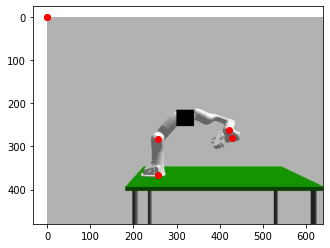

In [37]:
weights_path = '/home/jc-merlab/Pictures/Data/trained_models/keypointsrcnn_weights_occ_b4_e30_v1.pth'

model = torch.load(weights_path).to(device)


image = Image.open("/home/jc-merlab/Pictures/Data/planar_occluded/002612.rgb.jpg")
print(type(image))

img = F.to_tensor(image).to(device)
img.unsqueeze_(0)
# print(image.shape)
# image = list(image)
# print(type(images))
# images = list(image.to(device) for image in images)

with torch.no_grad():
    model.to(device)
    model.eval()
    output = model(img)
    
keypoints = output[0][0]

print(keypoints)
plt.imshow(image)

# Assuming each keypoint is a tensor representing (x, y)
for i, keypoint in enumerate(keypoints):
    print(f'Key point {i}: {keypoint}')
    keypoint = keypoint.cpu().numpy()
    plt.plot(keypoint[0], keypoint[1], 'ro')
plt.show()

# Plotting the image

# plt.imshow(image)

# for keypoint in output[0]:
#     plt.plot(keypoint[0], keypoint[1], 'ro')

# plt.show()